# Using with a spreadsheet-based configuration

`ecodynelec` offers the possibility to configure the execution via a spreadsheet, for more user-friendly handling. This tutorial shows the different steps and possibilities in this regard. As `ecodynelec` is firstly designed for research purposes, there also is the possibility to entirely rely on a python-based configuration , as developed  in the "[Using fully with Python](https://ecodynelec.readthedocs.io/en/latest/examples/with_python.html)" tutorial.

## Initialization

To download and install `ecodynelec` to being used as a python package, the user is referred to either the [getting started tutorial](https://ecodynelec.readthedocs.io/en/latest/examples/getting_started.html).

## Configuration

The configuration of `ecodynelec` is to be handled in a spreadsheet. Figure 1-3 show the three sections of the spreadsheet used in this example. The spreadsheet can be downloaded from the [github repository](https://github.com/LESBAT-HEIG-VD/EcoDynElec/raw/main/examples/Spreadsheet_example.xlsx).

The configuration is composed of 3 parts. The detail about the meaning of each is developed in the [input data section](https://ecodynelec.readthedocs.io/en/latest/data_input/parameters.html).

![Main Tab Spreadsheet](https://github.com/LESBAT-HEIG-VD/EcoDynElec/blob/main/docs/examples/images/ParameterExcel_ParamExample.png?raw=true)\
*Figure 1: Spreadsheet for configuration: main Parameter tab*

the <u>first tab</u> (*Figure 1*) contains the elements to configure the execution itself.

![Filepath Tab Spreadsheet](https://github.com/LESBAT-HEIG-VD/EcoDynElec/blob/main/docs/examples/images/ParameterExcel_PathsExample.png?raw=true)\
*Figure 2: Spreadsheet for configuration: Paths tab*

the <u>second tab</u> (*Figure 2*) deals with all paths to information files, directory containing information, or where to write and save information before, during and after the computation. **Note** that, for the `generation`, `exchanges` and `savedir` directories fields, the specified directory *will be created if it does not already exist*. For every other file path element, *a default file* is used if the field is left blank, and an error is returned if the information passed does not correspond to any existing file on your local machine.

![Server tab Spreadsheet](https://github.com/LESBAT-HEIG-VD/EcoDynElec/blob/main/docs/examples/images/ParameterExcel_ServerExample.png?raw=true)\
*Figure 3: Spreadsheet for configuration: Server tab*

the <u>third tab</u> (*Figure 3*) deals with information related to the ENTSO-E server, as electricity data from the ENTSO-E server is at the center of `ecodynelec`. More on this topic is covered on the next paragraph and on the dedicated [downloading tutorial](https://ecodynelec.readthedocs.io/en/latest/examples/downloading.html). **Note** that per default, the field `use server` is set to FALSE, i.e. no download will occur. Also note that the `username` field is supposed to be an email address.

### Downloading Entso-E data

The [downloading tutorial](https://ecodynelec.readthedocs.io/en/latest/examples/downloading.html) covers the specificities about how to download the ENTSO-E data or include the download as part of the `ecodynelec` pipeline execution. This feature is not triggered per default and `ecodynelec` is expecting to find already downloaded ENTSO-E files.

## Execution

`ecodynelec` is build out of a myriad of modules that can be used relatively independently, under the condition that inputs data is shaped the correct way. Fortunately, the entire pipeline starting from a set of parameters and computing down to the calculation of impact metrics.

The usage of this entire pipeline is demonstrated below. This pipeline allows to save results into files (c.f. paragraph on [configuration](https://ecodynelec.readthedocs.io/en/latest/examples/with_spreadsheet.html#configuration)). However results are also always returned for further in-script use. These results are stored in the `impacts` variable for later paragraphs in this tutorial.

In [28]:
from ecodynelec.pipelines import execute

In [29]:
from ecodynelec.parameter import Parameter
p = Parameter(excel='./Spreadsheet_download.xlsx')
print('p is ', p)

p is  ctry --> ['AT', 'CH', 'DE', 'FR', 'IT']
target --> CH
start --> 2022-01-05 00:00:00
end --> 2022-12-30 23:00:00
freq --> H
timezone --> UTC
cst_imports --> False
net_exchanges --> False
network_losses --> False
sg_imports --> False
residual_local --> False
residual_global --> False
data_cleaning --> True

Filepath to generation --> C:\Users\aymeric.bourdy\PycharmProjects\EcoDynElec\examples\test_data\downloads\generations/
Filepath to exchanges --> C:\Users\aymeric.bourdy\PycharmProjects\EcoDynElec\examples\test_data\downloads\exchanges/
Filepath to savedir --> None
Filepath to ui_vector --> None
Filepath to mapping --> None
Filepath to neighbours --> None
Filepath to gap --> None
Filepath to swissGrid --> None
Filepath to networkLosses --> None
 
Server for useServer --> True
Server for host --> sftp-transparency.entsoe.eu
Server for port --> 22
Server for username --> aymericb5@gmail.com
Server for password --> ********
Server for removeUnused --> False
Server for _remoteGenera

In [30]:
impacts = execute(config="./Spreadsheet_download.xlsx", is_verbose=True)

Download Entso-E data from server...
	Download from server: 304.65 sec                                        n 2/12] Transferred: 0.2 MB	Out of: 132.8          [Generation 2/12] Transferred: 1.9 MB	Out of: 132.8          [Generation 2/12] Transferred: 3.6 MB	Out of: 132.8          [Generation 2/12] Transferred: 5.4 MB	Out of: 132.8          [Generation 2/12] Transferred: 7.2 MB	Out of: 132.8          [Generation 2/12] Transferred: 9.1 MB	Out of: 132.8          [Generation 2/12] Transferred: 11.2 MB	Out of: 132.8          [Generation 2/12] Transferred: 13.2 MB	Out of: 132.8          [Generation 2/12] Transferred: 15.3 MB	Out of: 132.8          [Generation 2/12] Transferred: 17.2 MB	Out of: 132.8          [Generation 2/12] Transferred: 19.5 MB	Out of: 132.8          [Generation 2/12] Transferred: 21.8 MB	Out of: 132.8          [Generation 2/12] Transferred: 24.1 MB	Out of: 132.8          [Generation 2/12] Transferred: 26.4 MB	Out of: 132.8          [Generation 2/12] Transferred: 28.8 MB

## Outcome and Visualization

The outcome is stored in files and returned for further in-script use. In the previous section, results were stored in the `impacts` variable. The current section highlights the content returned and shows some basic possibilities for data visualization.

In [31]:
import numpy as np
import pandas as pd

### Description of the outcome

The `impacts` variable contains a collection of tables. This collection is a `dict` with one `Global` key, and one other key per impact category:

In [32]:
print(impacts.keys())

dict_keys(['Global', 'Climate Change', 'Human carcinogenic toxicity', 'Fine particulate matter formation', 'Land use'])


The `Global` table is the *sum across all technologies* for each index, as it is shown for the first few time steps:

In [33]:
display(impacts['Global'].head())

,Climate Change,Human carcinogenic toxicity,Fine particulate matter formation,Land use
2022-01-05 00:00:00,0.188833,0.017684,0.000124,0.004593
2022-01-05 01:00:00,0.163029,0.015745,0.000110,0.004208
2022-01-05 02:00:00,0.149948,0.015026,0.000103,0.004171
2022-01-05 03:00:00,0.155152,0.015601,0.000105,0.004196
2022-01-05 04:00:00,0.170565,0.016721,0.000112,0.004106


The other tables are, for each impact category, the breakdown into all possible sources:

In [34]:
for i in impacts: # Iterate for all impact categories
    if i=='Global': continue; # Skip the Global, already visualized above.
    
    print(f"#############\nimpacts for {i}:")
    display( impacts[i].head(3).T ) # Transpose table for readability

#############
impacts for Climate Change:


,2022-01-05 00:00:00,2022-01-05 01:00:00,2022-01-05 02:00:00
Climate Change_source,,,
Mix_Other,0.012500,0.010569,0.010005
Biomass_AT,0.000313,0.000279,0.000299
Fossil_Brown_coal/Lignite_AT,0.000000,0.000000,0.000000
Fossil_Coal-derived_gas_AT,0.000000,0.000000,0.000000
Fossil_Gas_AT,0.004322,0.003566,0.003805
...,...,...,...
Other_renewable_IT,0.000000,0.000000,0.000000
Solar_IT,0.000000,0.000000,0.000000
Waste_IT,0.000000,0.000000,0.000000


#############
impacts for Human carcinogenic toxicity:


,2022-01-05 00:00:00,2022-01-05 01:00:00,2022-01-05 02:00:00
Human carcinogenic toxicity_source,,,
Mix_Other,0.000833,0.000705,0.000667
Biomass_AT,0.000022,0.000019,0.000021
Fossil_Brown_coal/Lignite_AT,0.000000,0.000000,0.000000
Fossil_Coal-derived_gas_AT,0.000000,0.000000,0.000000
Fossil_Gas_AT,0.000031,0.000026,0.000027
...,...,...,...
Other_renewable_IT,0.000000,0.000000,0.000000
Solar_IT,0.000000,0.000000,0.000000
Waste_IT,0.000000,0.000000,0.000000


#############
impacts for Fine particulate matter formation:


,2022-01-05 00:00:00,2022-01-05 01:00:00,2022-01-05 02:00:00
Fine particulate matter formation_source,,,
Mix_Other,0.000018,0.000015,0.000015
Biomass_AT,0.000001,0.000001,0.000001
Fossil_Brown_coal/Lignite_AT,0.000000,0.000000,0.000000
Fossil_Coal-derived_gas_AT,0.000000,0.000000,0.000000
Fossil_Gas_AT,0.000001,0.000001,0.000001
...,...,...,...
Other_renewable_IT,0.000000,0.000000,0.000000
Solar_IT,0.000000,0.000000,0.000000
Waste_IT,0.000000,0.000000,0.000000


#############
impacts for Land use:


,2022-01-05 00:00:00,2022-01-05 01:00:00,2022-01-05 02:00:00
Land use_source,,,
Mix_Other,0.000360,0.000304,0.000288
Biomass_AT,0.000961,0.000858,0.000920
Fossil_Brown_coal/Lignite_AT,0.000000,0.000000,0.000000
Fossil_Coal-derived_gas_AT,0.000000,0.000000,0.000000
Fossil_Gas_AT,0.000016,0.000013,0.000014
...,...,...,...
Other_renewable_IT,0.000000,0.000000,0.000000
Solar_IT,0.000000,0.000000,0.000000
Waste_IT,0.000000,0.000000,0.000000


### Group per country

The following piece of code suggests a basic visualization of the Climate Change category, grouping the results per country of origin of the tracked electricity.

In [35]:
def compute_per_country(results):
    """Function to group results per country"""
    countries = np.unique([c.split("_")[-1] for c in results.columns]) # List of countries
    
    per_country = []
    for c in countries:
        cols = [k for k in results.columns if k[-3:]==f"_{c}"]
        per_country.append(pd.Series(results.loc[:,cols].sum(axis=1), name=c))
        
    return pd.concat(per_country,axis=1)

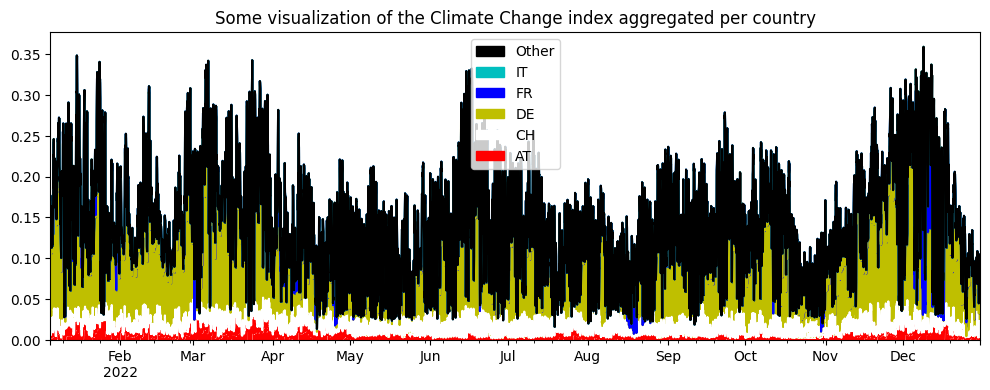

In [36]:
gwp_per_country = compute_per_country(impacts['Climate Change']) # Group Climate Change index impacts per country
gwp_per_country.plot.area(figsize=(12,4), legend='reverse', color=['r','w','y','b','c','k'],
                          title="Some visualization of the Climate Change index aggregated per country"); # Build the graph

### Group per production type

The following piece of code suggests a basic visualization of the Climate Change category, grouping the results per technology of origin of the tracked electricity.

In [37]:
def compute_per_type(results):
    """Function to group datasets per type of unit, regardless of the country of origin"""
    unit_list = np.unique([k[:-3] if k[-3]=="_" else k for k in results.columns]) # List the different production units
    
    per_unit = []
    for u in unit_list:
        cols = [k for k in results.columns if k[:-3]==u] # collect the useful columns
        per_unit.append(pd.Series(results.loc[:,cols].sum(axis=1), name=u)) # aggregate

    return pd.concat(per_unit,axis=1)

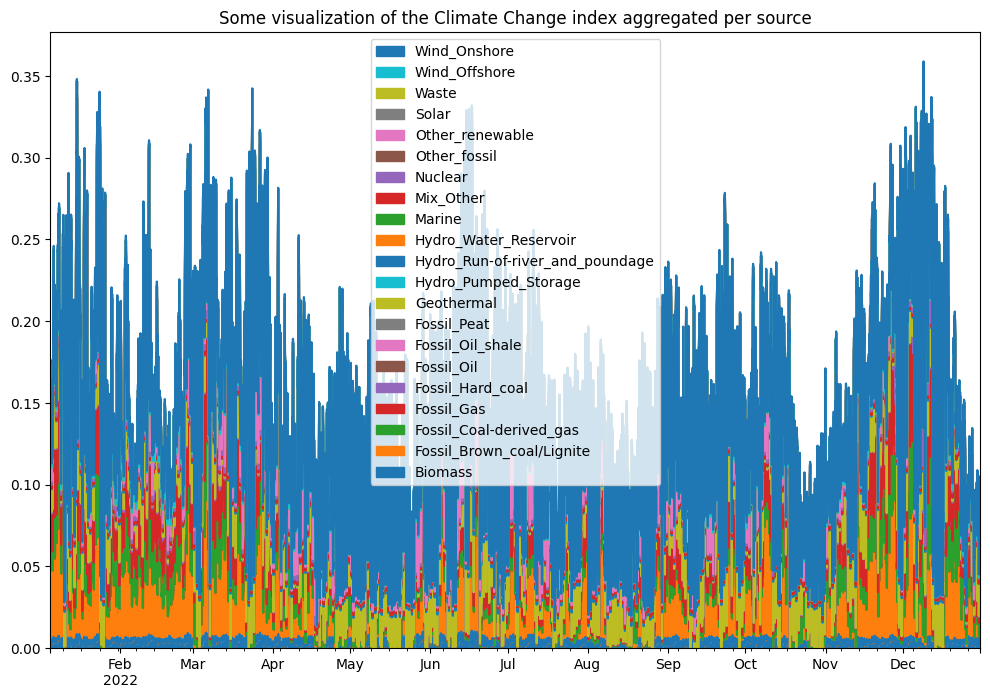

In [38]:
es13_per_type = compute_per_type(impacts['Climate Change']) # Group Climate Change index impacts per country
es13_per_type.plot.area(figsize=(12,8), legend='reverse',
                        title="Some visualization of the Climate Change index aggregated per source"); # Build the graph